In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("/content/Emotion_final.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [3]:
# melakukan proses one-hot-encoding dan membuat dataframe baru
category = pd.get_dummies(df.Emotion)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Emotion')
df_baru

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
21454,Melissa stared at her friend in dism,0,1,0,0,0,0
21455,Successive state elections have seen the gover...,0,1,0,0,0,0
21456,Vincent was irritated but not dismay,0,1,0,0,0,0
21457,Kendall-Hume turned back to face the dismayed ...,0,1,0,0,0,0


In [4]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array 
text = df_baru["Text"].values
label = df_baru[["anger", "fear", "happy", "love", "sadness", "surprise"]].values

# membagi data set menjadi train dan test set
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [106]:
# proses tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="x")
tokenizer.fit_on_texts(text_latih)
tokenizer.fit_on_texts(text_test)

sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)

# mengubah kalimat ke dalam sequence
padded_latih = pad_sequences(sekuens_latih,
                             padding="post",
                             maxlen=45,
                             truncating="post")
padded_test = pad_sequences(sekuens_test,
                            padding="post",
                            maxlen=45,
                            truncating="post")

In [107]:
# pembuatan model menggunakan sequential
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(64), # penggunaan teknik LSTM
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [108]:
# memanggil fungsi compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [109]:
# membuat callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.9) and (logs.get("val_accuracy") > 0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [110]:
# melatih model 
num_epochs = 30
history = model.fit(padded_latih, label_latih,
                    batch_size=32, # menambahkan batch loading
                    epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    callbacks=[callbacks], # pemanggilan callbacks
                    verbose=2)

Epoch 1/30
537/537 - 74s - loss: 1.5912 - accuracy: 0.3170 - val_loss: 1.4919 - val_accuracy: 0.2894 - 74s/epoch - 138ms/step
Epoch 2/30
537/537 - 19s - loss: 1.1800 - accuracy: 0.4116 - val_loss: 1.0448 - val_accuracy: 0.4695 - 19s/epoch - 36ms/step
Epoch 3/30
537/537 - 19s - loss: 0.9348 - accuracy: 0.4841 - val_loss: 0.9028 - val_accuracy: 0.5405 - 19s/epoch - 36ms/step
Epoch 4/30
537/537 - 20s - loss: 0.7571 - accuracy: 0.5747 - val_loss: 0.7291 - val_accuracy: 0.5904 - 20s/epoch - 36ms/step
Epoch 5/30
537/537 - 20s - loss: 0.6078 - accuracy: 0.6512 - val_loss: 0.6574 - val_accuracy: 0.6475 - 20s/epoch - 38ms/step
Epoch 6/30
537/537 - 20s - loss: 0.5272 - accuracy: 0.7230 - val_loss: 0.5362 - val_accuracy: 0.8325 - 20s/epoch - 38ms/step
Epoch 7/30
537/537 - 20s - loss: 0.2228 - accuracy: 0.9254 - val_loss: 0.3196 - val_accuracy: 0.8956 - 20s/epoch - 37ms/step
Epoch 8/30
537/537 - 19s - loss: 0.1453 - accuracy: 0.9487 - val_loss: 0.3189 - val_accuracy: 0.8989 - 19s/epoch - 36ms/step

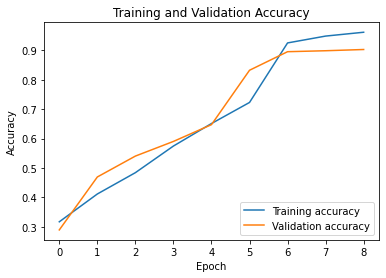

In [114]:
acc = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(acc))

plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

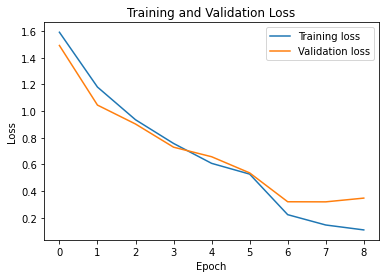

In [116]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()